In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf

import glob
import sys
import os
from collections import OrderedDict

import csv

sys.path.insert(0, "../casa/")
from plot_utils import *
from genome_utils import *

# General Setup
This is a small analysis of _NMU_.

Collecting files here.

In [2]:
NMR1_fn = '../data/NMU_rep1detailed.txt'
NMR2_fn = '../data/NMU_rep2detailed.txt'

fn_list = [NMR1_fn,NMR2_fn]

exp_ids = ['NMR1','NMR2']

fullinfo= [("NMU",1),("NMU",2)]

id2info = { exp_id: info for exp_id, info in zip(exp_ids, fullinfo) }

id2info['k27'] = ('H3K27ac', 1)
id2info['DHS'] = ('DHS', 1)

In [3]:
OR_str = 'lowOR'
# Peak BED files
# MAINTAIN ORDER (see exp_ids variable above)
NMR1_bed= '../data/NMU_rep1__{}peaks.bed'.format(OR_str)
NMR2_bed= '../data/NMU_rep2__{}peaks.bed'.format(OR_str)

exp_beds= [NMR1_bed, NMR2_bed]

K27_bed = '../data/k27ac_replicatePeaks_hg38_scoreFiltered.bed'
DHS_bed = '../data/DNASE_peaks_replicated.bed'

extra_beds = [ K27_bed, DHS_bed ]
extra_tags = [ 'k27', 'DHS' ]

# Load and preprocess data

In [4]:
gff = pd.read_table('../data/NMU_locus.gff')

/home/sagergosai/miniconda3/envs/casa/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  """Entry point for launching an IPython kernel.


In [5]:
gff

,name,chrom,strand,txStart,txEnd,cdsStart,cdsEnd,exonCount,exonStarts,exonEnds,proteinID,transcriptID,geneID
0,ENST00000506198.5,chr4,+,55395956,55425657,55396189,55425452,3,"55395956,55424537,55425375","55396396,55424643,55425657",D6RD79,uc062wsu.1,TMEM165
1,ENST00000513440.6,chr4,-,55427902,55546909,55435414,55482785,23,"55427902,55438281,55442431,55443686,55444632,5...","55435594,55438537,55442634,55443896,55444785,5...",O15516,uc003hba.4,CLOCK
2,ENST00000295645.9,chr4,-,55556518,55592245,55556556,55592109,6,"55556518,55562403,55569717,55580820,55582116,5...","55556711,55562612,55569861,55580911,55582237,5...",Q8N4E4,uc003hbb.4,PDCL2
3,ENST00000264218.7,chr4,-,55595230,55636298,55599145,55636192,10,"55595230,55599141,55600521,55605274,55607297,5...","55595411,55599181,55600575,55605349,55607348,5...",P48645,uc003hbc.3,NMU


In [6]:
data = []
for i, fn in enumerate(fn_list):
    d_pt = pd.read_table(fn,sep='\t',header=0)
    ## Rescale to floats
    rescale = min(d_pt['LS_reads'].sum(),d_pt['HS_reads'].sum()) / d_pt.loc[:,('HS_reads','LS_reads')].sum(axis=0)
    d_pt.loc[:,('HS_reads','LS_reads')] *= rescale
    ## Sample downsized library
    runif              = np.random.uniform(size=d_pt.loc[:,('HS_reads','LS_reads')].shape)
    int_part, sample_p = np.divmod( d_pt.loc[:,('HS_reads','LS_reads')], 1 )
    d_pt.loc[:,('HS_reads','LS_reads')] = int_part + (runif < sample_p)
    ## Return as int
    d_pt.loc[:,('HS_reads','LS_reads')] = d_pt.loc[:,('HS_reads','LS_reads')].astype(int) + 1
    d_pt[exp_ids[i]] = np.log( d_pt['LS_reads'] / d_pt['HS_reads'] )
    data.append( d_pt.loc[((~d_pt['Coordinates'].str.contains("CTRL")) &\
                           (~d_pt['Coordinates'].str.contains("NT")) &\
                           (~d_pt['Coordinates'].str.contains('FILLER-LV2')) &\
                           (~d_pt['Coordinates'].str.contains('FILLER-SgO'))),
                          ('Coordinates',exp_ids[i])] )

/home/sagergosai/miniconda3/envs/casa/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: read_table is deprecated, use read_csv instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [7]:
data = pd.concat([ df.set_index('Coordinates') for df in data ],axis=1)

In [8]:
data['cutsite'] = [ int(coord.split(':')[1].split('-')[1]) - 4 
                      if coord.split(':')[-1] == '+' 
                      else 
                    int(coord.split(':')[1].split('-')[0]) + 3 
                      for coord in data.index ]

In [9]:
# Get experimental peaks
## Read in files
test_peaks = [ pd.read_table(
                 fn,sep='\t',header=None,
                 names=['chr','start','end','hdr','pass','strand']
               ) 
               for fn in exp_beds ]
## Figure out which chromosomes were tested
tested_chr = pd.concat( test_peaks, axis=0 )['chr'].unique()
## Filter out non-significant peaks
test_peaks = [ merge_bed(
                   df.loc[ df['pass'] == True, ('chr','start','end') ].copy()
               )
               for df in test_peaks ]
## Filter out tiny peaks
test_peaks = [ df[ (df['end'] - df['start']) > 100 ]
               for df in test_peaks ]

print("Experimental track count: {}".format(len(test_peaks)))

# Add on extra features from ENCODE
## Read in files
extra_feat = [ pd.read_table(fn,sep='\t',header=None,
                             names=['chr','start','end'],usecols=[0,1,2]) 
               for fn in extra_beds ]
## Filter out un-tested chromosomes for speed
chr_filters = [ np.vstack([feat['chr'] == chrom for chrom in tested_chr ]).any(axis=0) 
                for feat in extra_feat ]

# Combine
[ test_peaks.append( feat.loc[ chr_filter ,:] ) for feat, chr_filter in zip(extra_feat, chr_filters) ]
test_peaks = [ df.reset_index(drop=True) for df in test_peaks ]
print("Total track count: {}".format(len(test_peaks)))
for exp_id, peaks_idx in zip(exp_ids+extra_tags,range(len(test_peaks))):
    test_peaks[peaks_idx]['exp_id'] = exp_id
    test_peaks[peaks_idx]['assay'] = id2info[exp_id][0]
    test_peaks[peaks_idx]['replicate'] = id2info[exp_id][1]
    
test_peaks = pd.concat(test_peaks,axis=0,ignore_index=True)


Experimental track count: 2
Total track count: 4


/home/sagergosai/miniconda3/envs/casa/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: read_table is deprecated, use read_csv instead.
  import sys
/home/sagergosai/miniconda3/envs/casa/lib/python3.7/site-packages/ipykernel_launcher.py:25: FutureWarning: read_table is deprecated, use read_csv instead.


# Plot guide-wise scores with peaks
Lines indicate min-max interval between all replicates.

NMU
49


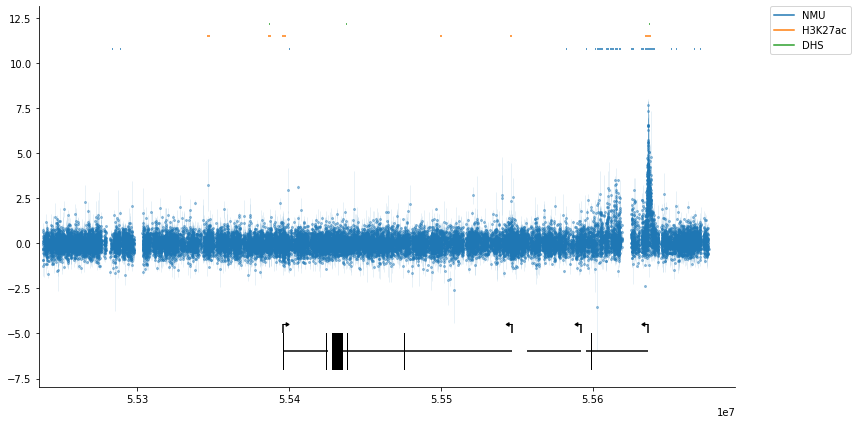

In [10]:
fig_h = plot_combined_cutsites(np.array([[55234872,55694054]]), 
                  data, test_peaks, plot_ids=['NMR1','NMR2','k27','DHS'], get_chrom='chr4')
draw_genes_from_gff(fig_h[1], gff, promoter_params=[2000,0.2,2000])

NMU
35


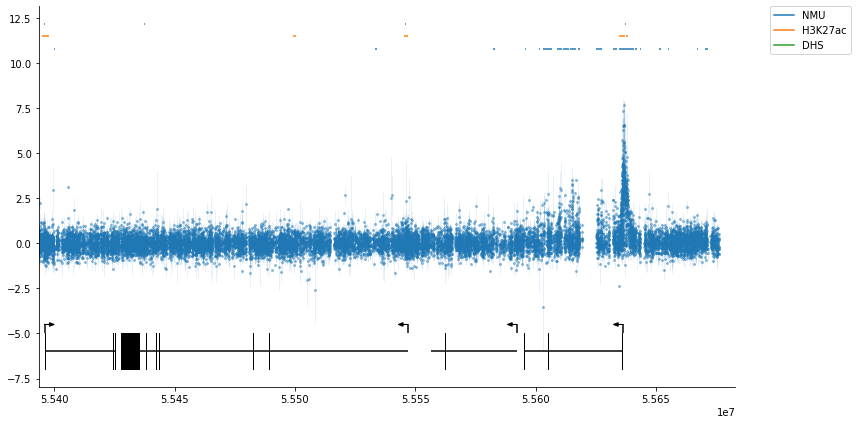

In [11]:
fig_h = plot_combined_cutsites(np.array([[55393455,55683032]]), 
                  data, test_peaks, plot_ids=['NMR1','NMR2','k27','DHS'], get_chrom='chr4')
draw_genes_from_gff(fig_h[1], gff, promoter_params=[2000,0.2,2000])

NMU
2


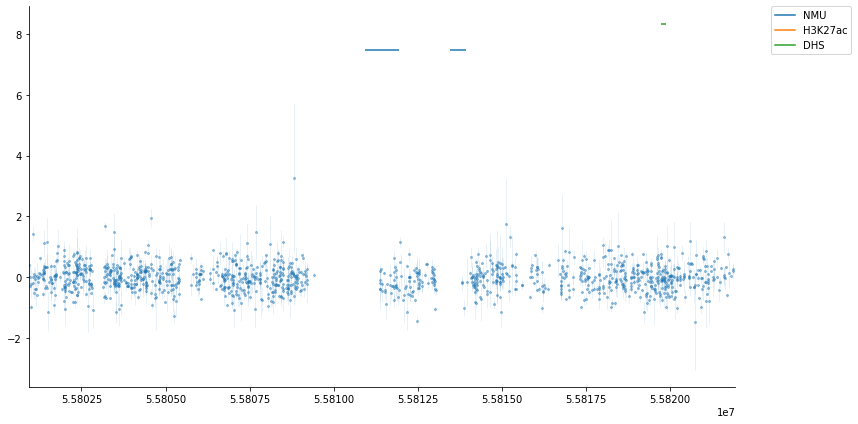

In [12]:
fig_h = plot_combined_cutsites(np.array([[55810941-10000,55811941+10000]]), 
                  data, test_peaks, plot_ids=['NMR1','NMR2','k27','DHS'], get_chrom='chr4')


# Connection diagram
Summarize CRE promoter interactions

In [13]:
txn_starts = extract_txn_starts(gff)

pack_TSSs   = [('NMU',txn_starts['NMU'][0],txn_starts['NMU'][1])]

In [14]:
txn_starts

{'TMEM165': ('chr4', 55395956),
 'CLOCK': ('chr4', 55546909),
 'PDCL2': ('chr4', 55592245),
 'NMU': ('chr4', 55636298)}

In [15]:
NMU_only_peaks = filter_by_guide_coverage(
    get_replicating_peaks( test_peaks[(test_peaks['assay'] == 'NMU')] ), 
    pd.read_table(NMR1_fn,sep='\t',header=0)['Coordinates'], min_coverage=29
)

pack_peaks       = [NMU_only_peaks]

all_locus_peaks = pd.concat(pack_peaks).reset_index(drop=True)

/home/sagergosai/miniconda3/envs/casa/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: read_table is deprecated, use read_csv instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [16]:
all_locus_peaks

,chr,start,end,guide_coverage
0,chr4,55602941,55606941,174
1,chr4,55608941,55610941,132
2,chr4,55611441,55613941,139
3,chr4,55614441,55616941,165
4,chr4,55617441,55618441,86
5,chr4,55624941,55627441,151
6,chr4,55631941,55633941,122
7,chr4,55634441,55640941,688
8,chr4,55666941,55667441,54
9,chr4,55670441,55671441,67


In [17]:
NMU_total_scores = get_peak_strengths(NMR1_bed, NMR2_bed)

pack_scores = [NMU_total_scores]


../casa/plot_utils.py:312: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  for fn in argv ]


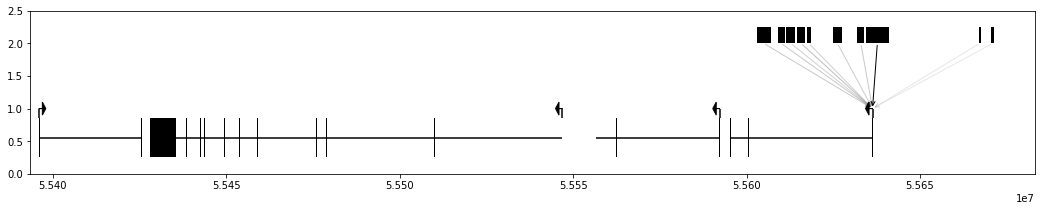

In [18]:
fig = plt.figure(figsize=(18,3))
ax  = plt.subplot(111)
glims = [55393455,55683032]
ax.set_xlim( *glims )
ax.set_ylim(0.0, 2.5)
draw_genes_from_gff(ax, gff, promoter_params=[1000,0.2,1000], gene_ylim=[0.25,1.0])
draw_bed_blocks(ax, all_locus_peaks, ylims=[2.0,2.25])
connect_bed_to_genes(ax, all_locus_peaks, txn_starts['NMU'], y_anchor=2.0, y_target=1.0, score_bed=NMU_total_scores, xlims=glims)

plt.savefig('plots/NMU_locus__55393455_55683032__connectogram__{}.pdf'.format(OR_str))

plt.show()

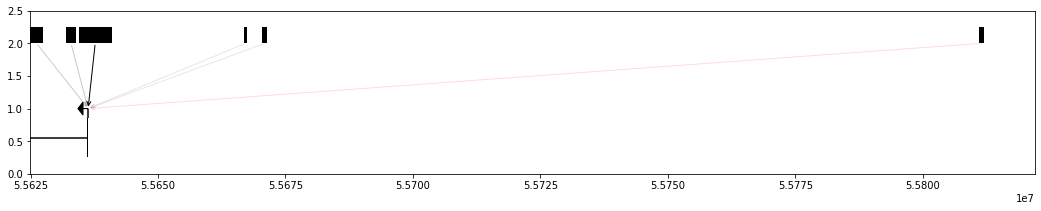

In [20]:
fig = plt.figure(figsize=(18,3))
ax  = plt.subplot(111)
glims = [55624941,55821941]
ax.set_xlim( *glims )
ax.set_ylim(0.0, 2.5)
draw_genes_from_gff(ax, gff, promoter_params=[1000,0.2,1000], gene_ylim=[0.25,1.0])
draw_bed_blocks(ax, all_locus_peaks, ylims=[2.0,2.25])
connect_bed_to_genes(ax, all_locus_peaks, txn_starts['NMU'], y_anchor=2.0, y_target=1.0, score_bed=NMU_total_scores, xlims=glims)

plt.savefig('plots/NMU_locus__55624941_55821941__connectogram__{}.pdf'.format(OR_str))

plt.show()

In [19]:
write_bed_format([ x.iloc[:,0:3] for x in pack_peaks ], pack_scores, pack_TSSs, 
                 '../data/NMU_locus__replicating_peaks__{}.bed'.format(OR_str))